Imports.

In [25]:
import polars as pl
import numpy as np
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import platform
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import random

In [26]:
print(torch.__version__, torch.cuda.is_available(), platform.python_version())
device = "mps" if torch.backends.mps.is_available() else "cpu"

2.7.1 False 3.12.1


Load the dataset.

In [ ]:
ds_train = MNIST(root=".", download=True, train=True, transform=ToTensor())

Sanity checks.

shape: (10, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ i64   ┆ u32   │
╞═══════╪═══════╡
│ 0     ┆ 5923  │
│ 1     ┆ 6742  │
│ 2     ┆ 5958  │
│ 3     ┆ 6131  │
│ 4     ┆ 5842  │
│ 5     ┆ 5421  │
│ 6     ┆ 5918  │
│ 7     ┆ 6265  │
│ 8     ┆ 5851  │
│ 9     ┆ 5949  │
└───────┴───────┘


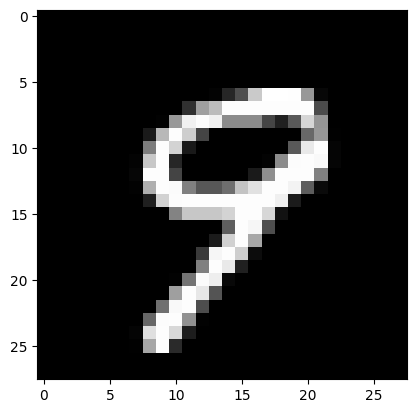

In [28]:
# flatten images / process data
labels = pl.Series(name="label", values=ds_train.targets)
print(labels.value_counts().sort("label"))

random_num = ds_train.data[random.randint(0, len(ds_train))]
plt.imshow(random_num.reshape((28, 28)), cmap="gray")
plt.show()

Define the MLP.

In [29]:
class MLP(nn.Module):
    def __init__(self, in_dim=784, hidden_dim=128, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.net(x)

Instantiate training pre-conditions.

In [32]:
EPOCHS = 10
BATCH_SIZE = 128

In [34]:
train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
model = MLP().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

Training loop.

In [40]:
losses = np.zeros((len(train), EPOCHS))
for epoch in tqdm(range(EPOCHS)):
    running_loss = 0.0
    train_iter = iter(train)
    for sample_idx, (imgs, labels) in enumerate(train_iter):
        imgs = imgs.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running_loss += loss.item()
        losses[sample_idx, epoch] = loss.item()
    avg = running_loss / len(train)
    print(f"Epoch {epoch+1}/{EPOCHS}  |  loss: {avg:.4f}")

 10%|█         | 1/10 [00:02<00:19,  2.20s/it]

Epoch 1/10  |  loss: 0.2271


 20%|██        | 2/10 [00:04<00:17,  2.15s/it]

Epoch 2/10  |  loss: 0.1967


 30%|███       | 3/10 [00:06<00:14,  2.11s/it]

Epoch 3/10  |  loss: 0.1725


 40%|████      | 4/10 [00:08<00:12,  2.10s/it]

Epoch 4/10  |  loss: 0.1537


 50%|█████     | 5/10 [00:10<00:10,  2.10s/it]

Epoch 5/10  |  loss: 0.1374


 60%|██████    | 6/10 [00:12<00:08,  2.11s/it]

Epoch 6/10  |  loss: 0.1237


 70%|███████   | 7/10 [00:14<00:06,  2.12s/it]

Epoch 7/10  |  loss: 0.1124


 80%|████████  | 8/10 [00:17<00:04,  2.15s/it]

Epoch 8/10  |  loss: 0.1025


 90%|█████████ | 9/10 [00:19<00:02,  2.13s/it]

Epoch 9/10  |  loss: 0.0945


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

Epoch 10/10  |  loss: 0.0874


Text(0, 0.5, 'Cross-entropy loss')

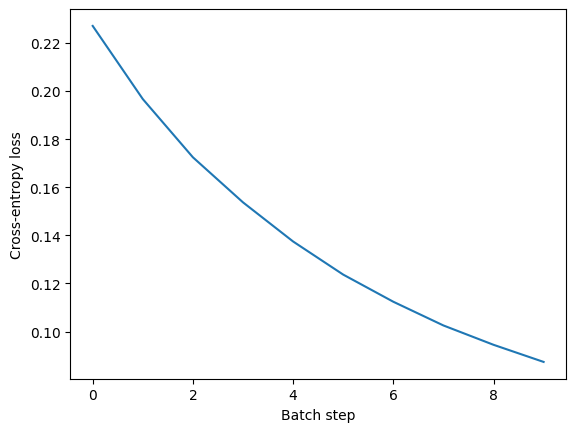

In [42]:
average_epoch_losses = np.mean(losses, axis=0)
plt.plot(average_epoch_losses)
plt.xlabel("Batch step")
plt.ylabel("Cross-entropy loss")

Evaluation.

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (28x28 and 784x128)

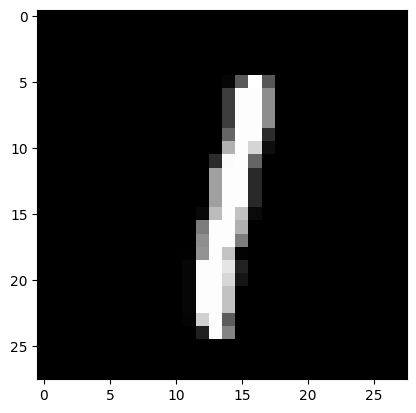

In [ ]:
ds_test = MNIST(root=".", download=True, train=False, transform=ToTensor())
test = DataLoader(ds_test, shuffle=True)
correct = total = 0



plt.imshow(imgs[0].cpu().numpy().reshape((28, 28)), cmap="gray")
model(imgs[0].to(device)).argmax()